<hr>  

#### About this document
_This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006) <br>This is a self contained Jupyter notebook with structure introduction, discussion and embeded code and bibliography._
<br>

**Code is hosted [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/blob/master/cw_casa06.ipynb)**<br>

**Data is availble [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/tree/master/data)**<br>

<hr>

# Analysis and prediction of regional demand for taxis based on spatiotemporal sequence data: 
_the case of the New York City_  

This paper explores trip record data from the TLC in New York City, and based on the city's provided geographic boundaries, obtains temporal characteristics of demand relationships at the district level.  
It emphasizes the analysis of the changes in cab demand in each region over time to ultimately obtain a model that can predict changes in demand.


<hr>

# Guide
  * [1 Introduction](#1-introduction)
    + [1.1 Background](#11-background)
    + [1.2 Research question](#12-research-question)
    + [1.3 Requirements to run the analysis](#13-requirements-to-run-the-analysis)  
  * [2 Literature Review](#2-literature-review)
  * [3 Presentation of data](#3-presentation-of-data)
    + [3.1 Research area](#31-research-area)
    + [3.2 Data discription](#32-data-discription)
    + [3.3 Exploratory data analysis](#33-exploratory-data-analysis)
      - [3.3.1 Decision on handling of null values](#331-decision-on-handling-of-null-values)
      - [3.3.2 Overall demand trend](#332-overall-demand-trend)
      - [3.3.3 Regional demand trend](#333-regional-demand-trend)
  * [4 Methodology](#4-methodology)
  * [5 Analysis](#5-analysis)
    + [5.1 Training data preparation](#51-training-data-preparation)
    + [5.2 RF](#52-rf)
    + [5.3 LSTM](#53-lstm)
  * [6 Results and Discussion](#6-results-and-discussion)
    + [6.1 The result analysis of random forest](#61-the-result-analysis-of-random-forest)
    + [6.2 The result analysis of LSTM](#62-the-result-analysis-of-lstm)
  * [7 Conclusion](#7-conclusion)
  * [Bibliography](#bibliography)
  * [Appendix](#appendix)

## 1 Introduction

### 1.1 Background  

The analysis of taxi time-series data is of great significance in transportation research and urban planning. Meanwhile, the demand for taxi services in urban areas exhibits a cyclical pattern with fluctuations observed on an annual and regional basis. However, the outbreak of COVID-19 has disrupted this pattern, as seen in the sharp decline in demand during the first half of 2020. To address this challenge, machine learning algorithms such as random forest and LSTM have been utilized to predict taxi demand. While previous studies have explored the use of machine learning for taxi demand prediction, more research is needed to improve the accuracy of these models and enhance their practical applications in the transportation industry.


### 1.2 Research question  
The aim of this research is to analyze the spatiotemporal characteristics of taxi demand in different regions based on the time series data of New York City's taxi trips, and use machine learning algorithms to make predictions, in order to provide decision support for urban transportation planning and taxi service optimization. Specifically, our research question is: How to analyze the spatiotemporal characteristics of taxi demand in different regions based on the time series data of New York City's taxi trips, and use machine learning algorithms to predict the future changes in taxi demand in each region?

### 1.3 Requirements to run the analysis

An overview of packages used to run the analysis with brief explanation of their role.

In [1]:
# To import data and plot the result
import geopandas as gpd 
import matplotlib.pyplot as plt 
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

# To do the data cleaning 
import os
import pandas as pd

# Create progress bars to understand the data processing process and relieve anxiety
from tqdm import tqdm

# For RF
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# For LSTM
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

<hr>

## 2 Literature Review  

In recent years, many studies have pointed out that cab demand has certain characteristics in space (Yang Yue et al., 2009; Deng and Ji, 2011; Li et al., 2011; Yu et al., 2022). There are also studies to explore city-scale events through GPS data of cabs (Zhang et al., 2015).
Meanwhile, several studies have focused on predicting cab demand using machine learning algorithms. For example, an ARIMA model was used to predict cab demand based on GPS data (Moreira-Matias et al., 2013). However, few studies have compared the performance of different machine learning algorithms for cab demand prediction. Therefore, the research in this paper can fill the gap in this area.

<hr>

## 3 Presentation of data 

### 3.1 Research area

The study area is within the boundaries of the TLC Taxi Zone. The TLC Taxi Zone is a region defined by the TLC, which divides New York City into six major areas and 263 smaller zones. Each small zone is assigned a unique number. Taxi zone lookup table is [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/blob/master/data/taxi_zone_lookup.csv)

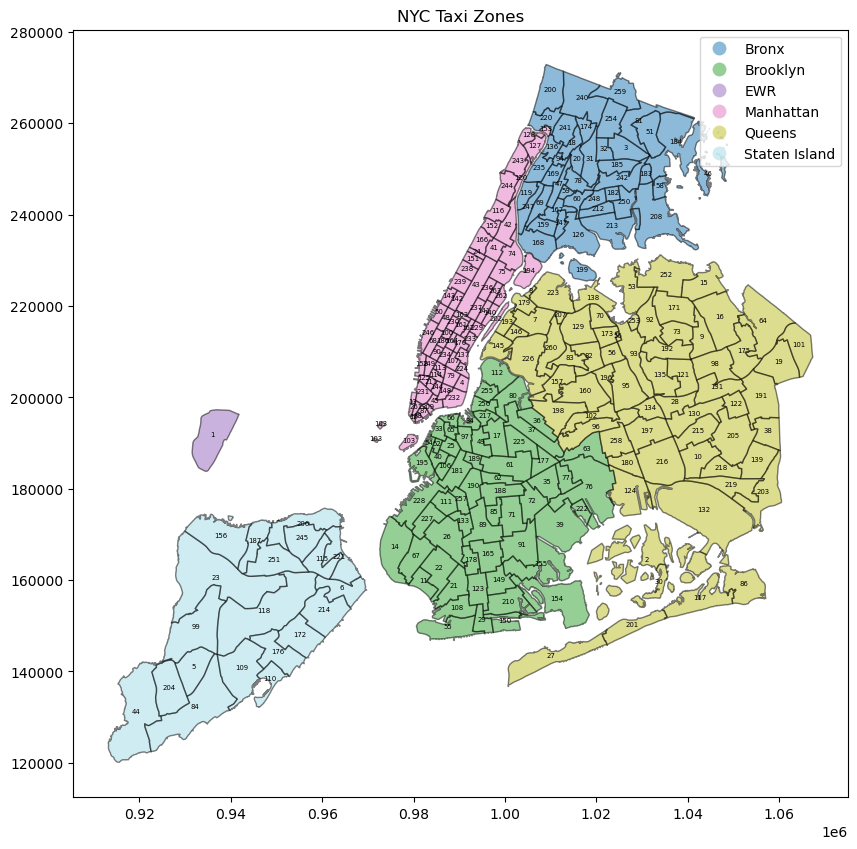

In [2]:
# Draw a map of the research area

# Read shapefile
shp_file = 'data/taxi_zones/taxi_zones.shp'
map_df = gpd.read_file(shp_file)

# Create a new figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot the GeoDataFrame and color the polygons based on the 'borough' column
map_df.plot(ax=ax, column='borough', cmap='tab20', alpha=0.5, edgecolor='k', legend=True)

# Add labels to each polygon
for idx, row in map_df.iterrows():
    ax.annotate(row['LocationID'], row['geometry'].centroid.coords[0], fontsize=5,horizontalalignment='center')

# Set the title of the plot
ax.set_title('NYC Taxi Zones')

# Show the plot
plt.show()

### 3.2 Data discription

The New York City Taxi and Limousine Commission (TLC) is the agency responsible for licensing and regulating taxis, commuter vans, and paratransit vehicles in New York City. The organization publicly releases TLC Trip Record Data on its official website. TLC Trip Record Data contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations for taxis.   

This article will mainly use the For-Hire Vehicle ("FHV") trip records from February 2019 to January 2023, for each month, to analyze and predict the spatial demand characteristics of taxis.

The fields of the FHV Trip Records that will be used in this article are as follows:       
|Field Name|Description|
|--|--|
|Pickup_datetime|The date and time of the trip pick-up|
|DropOff_datetime|The date and time of the trip dropoff|
|PULocationID|TLC Taxi Zone in which the trip began|
|DOLocationID|TLC Taxi Zone in which the trip ended|

The detailed data dictionary for the FHV Trip Records is as follows: [here](https://github.com/X-Fan-Jack/Taxis-prediction-in-NYC/blob/master/data/FHV_data/data_dictionary_trip_records_fhv.pdf)

### 3.3 Exploratory data analysis

#### 3.3.1 Decision on handling of null values

As the dataset is huge, cleaning missing values can have a significant impact on the size of the dataset, which in turn has a decisive influence on the quality of the regression model training results and the generalization of the model. Therefore, careful consideration is required in making decisions about the treatment of missing values.   
Firstly, since I need to consider the changes in the OD matrix, I only consider the "PULocationID" and "DOLocationID" fields with missing values. There are three cases of missing values for these two fields:       
|No.|State|
|--|--|
|1|Both Filled|
|2|One Null|
|3|Both Null|    

Based on the above three cases, there are two decisions for handling missing values: **_weak_** and **_strong_** cleaning decisions.     
The **_weak_** cleaning decision will check whether the "PULocationID" and "DOLocationID" fields contain missing values. If both fields are missing, the record will be removed. This decision means that if only one of the "PULocationID" and "DOLocationID" fields is missing, the record will be retained.   
The **_strong_** cleaning decision will check whether the "PULocationID" and "DOLocationID" fields contain missing values. If either field contains missing values, the record will be removed. This decision means that only records with both fields containing valid values will be retained.   

The main difference between the two decisions is whether records with only one missing value will be retained or not, i.e., the retention of State 2 in the table.   

For this paper, the focus is on the spatiotemporal characteristics of car demand in various regions of New York City, and using machine learning methods to predict changes in taxi demand. Therefore, we chose the weak cleaning decision to clean the data.

The reasons for choosing a weak cleaning decision are:     
1. because the focus is only on the demand for cars in each region, as much data as possible should be kept in order to speculate on the demand in each region.
2. Missing data can avoid over-fitting.

#### 3.3.2 Overall demand trend

This section examines the overall demand trend for taxis in the entire study area, using the pickup time of each trip as the time reference.

In [3]:
# Set the path to the FHV data directory
fhv_data_dir = "data/FHV_data"

# Initialize an empty time_list dataframe
time_list = pd.DataFrame(None, columns=["time", "count"])

In [4]:
# Iterate through the parquet files under all years in the FHV_data folder
for year_dir in tqdm(os.listdir(fhv_data_dir), desc="Reading File:"):
    year_path = os.path.join(fhv_data_dir, year_dir)
    if os.path.isdir(year_path) and year_dir.isdigit() and int(year_dir) >= 2019:
        for file_name in tqdm(os.listdir(year_path), desc="Calcualting:"):
            if file_name.endswith(".parquet"):
                file_path = os.path.join(year_path, file_name)
                # print('read:'+ file_path)
                # Read parquet file and convert to pandas dataframe
                table = pq.read_table(file_path)
                df = table.to_pandas(safe=False)
                
                # Verify that the pickup_datetime is within the year range indicated by the name of the folder where the file is located
                pickup_dates = pd.to_datetime(df["pickup_datetime"])
                mask = (pickup_dates.dt.year == int(year_dir))
                df = df[mask]
                
                # Count the number of orders for each day and append the results to the time_list
                counts = df["pickup_datetime"].dt.date.value_counts().sort_index()
                dates = counts.index
                
                time_list = pd.concat([time_list, pd.DataFrame({"time": dates, "count": counts.values})], ignore_index=True)
                
                # Release all the variable values created in the above step, except for time_list
                # del table, df, pickup_dates, mask, counts, dates

# Sort time_list by date and set date as index
# time_list = time_list.sort_values("time").set_index("time")
time_list = time_list.dropna(subset=['time'])
time_list = time_list.sort_values("time")
# time_list

Reading File:: 100%|██████████| 6/6 [00:41<00:00,  6.90s/it]


In [5]:
time_list.head()

,time,count
0,2019-02-01,70987
1,2019-02-02,56721
2,2019-02-03,49469
3,2019-02-04,62302
4,2019-02-05,60871


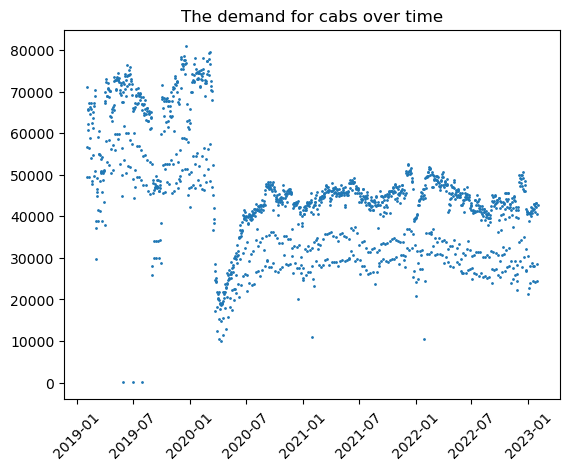

In [6]:
# Visualization in point 
plt.scatter(time_list['time'], time_list['count'], s=1)
plt.title("The demand for cabs over time")
plt.xticks(rotation=45)
plt.show()

The total number of trips fluctuated over the four-year period, with a peak in 2019 and a sharp decrease in 2020, likely due to the COVID-19 pandemic. The peak demand occurred in the summer months of 2019, with August having the highest number of trips. In contrast, the lowest demand was observed in April 2020, which coincides with the peak of the pandemic in New York City.

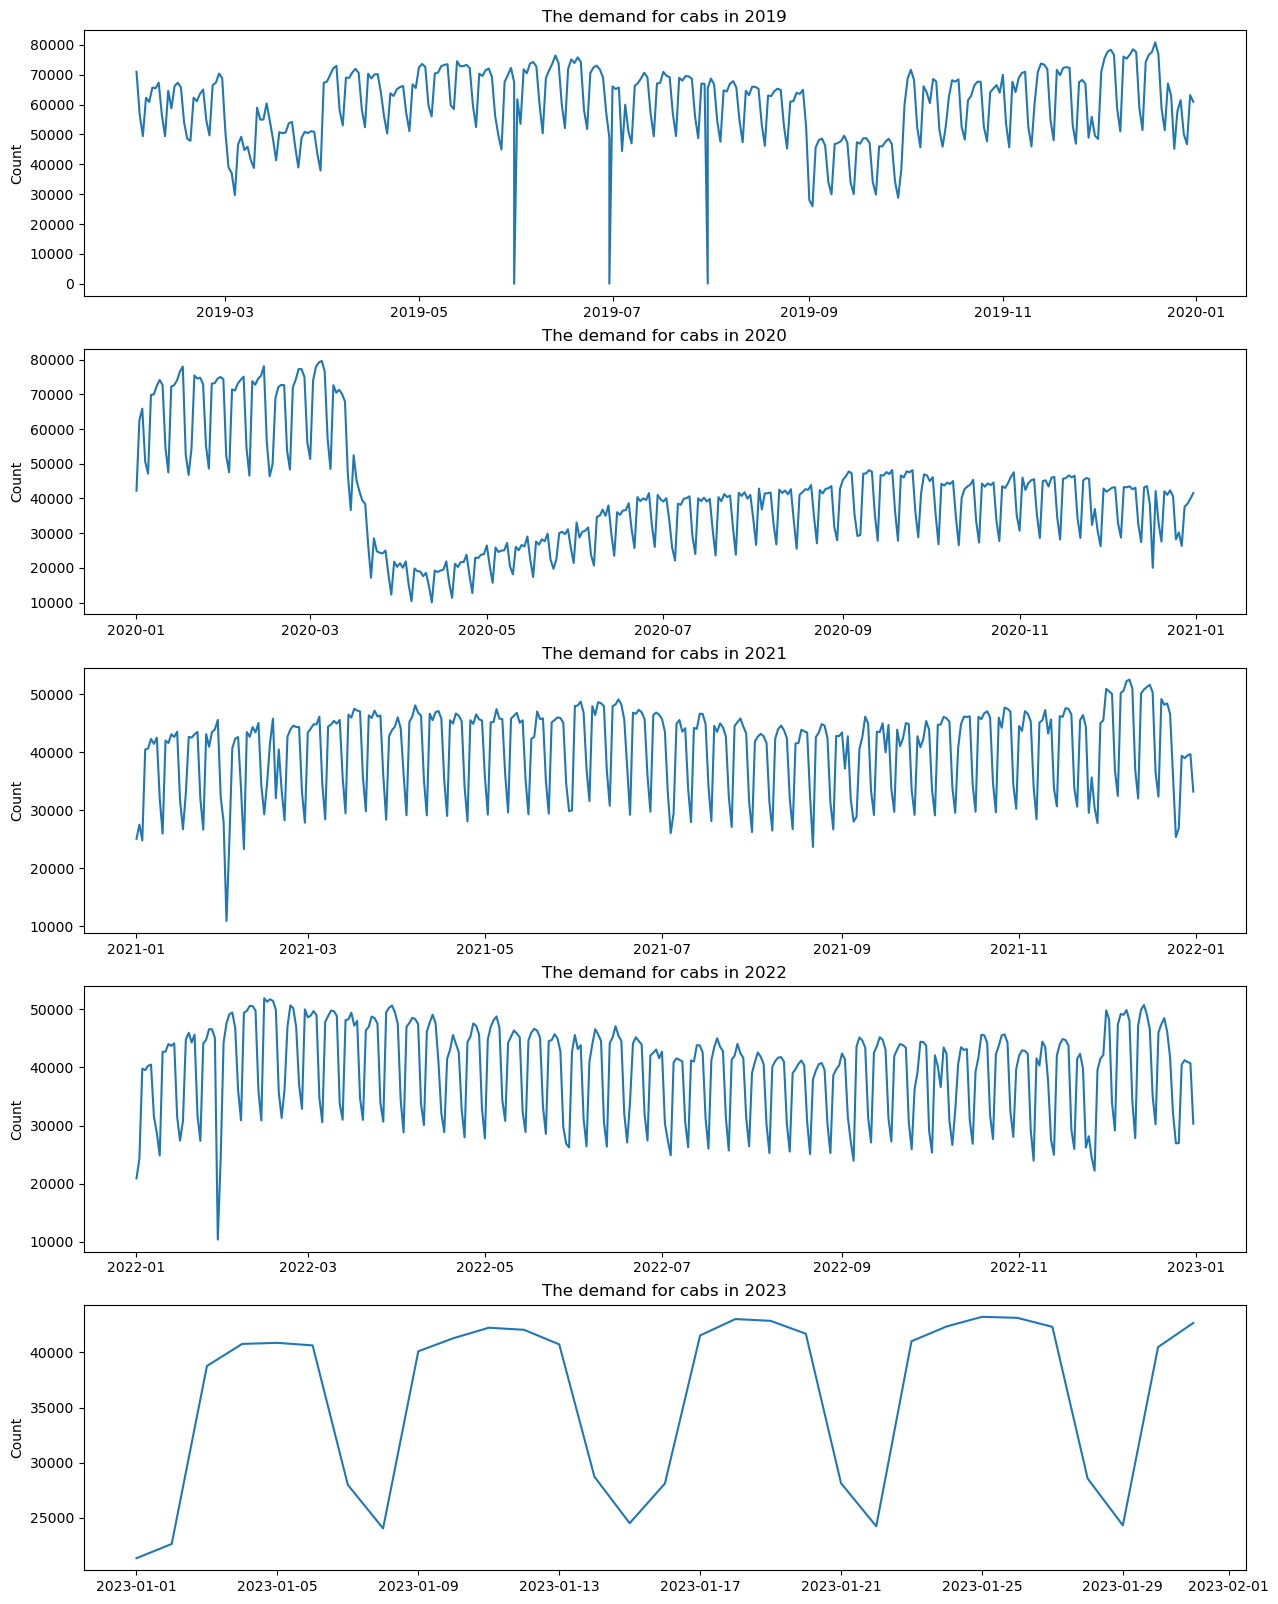

In [7]:
# Plot in year scale
df = time_list
df['time'] = pd.to_datetime(df['time'])

# Grouped by year
df_grouped = df.groupby(df['time'].dt.year)

# plot
fig, axs = plt.subplots(5, 1, figsize=(15, 20))
for i, (year, group) in enumerate(df_grouped):
    axs[i].plot(group['time'], group['count'])
    axs[i].set_title('The demand for cabs in ' + str(year))
    # axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Count')

plt.show()

To better understand the long-term trend, I calculated the daily number of trips from 2019 to 2023. The result shows a gradual increase in demand from 2019 to early 2020, followed by a sharp decline in April 2020, which persisted throughout the rest of the year. The demand slowly started to recover in early 2021, but it has not yet reached the pre-pandemic level.

#### 3.3.3 Regional demand trend

The variation in demand for taxi services across different regions in New York City is of great interest for both transportation planning and business operation purposes. To examine this, I analyzed the monthly demand patterns of taxi services from February 2019 to January 2023 for each of the 263 Taxi and Limousine Commission (TLC) zones.

In [8]:
# Read CSV lookup file
df_lookup = pd.read_csv('data/taxi_zone_lookup.csv')
df_lookup['LocationID'] = df_lookup['LocationID'].astype('category')
df_lookup

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [9]:
# Initialize values and create time_list_location to store final data
# Set the path to the FHV data directory
fhv_data_dir = "data/FHV_data"

# Initialize the empty time_list_location dataframe
time_list_location = pd.DataFrame(None)

# Read the data and store it in time_list_location
# Iterate through the parquet files under all years in the FHV_data folder
for year_dir in tqdm(os.listdir(fhv_data_dir), desc="Reading File:"):
    year_path = os.path.join(fhv_data_dir, year_dir)
    if os.path.isdir(year_path) and year_dir.isdigit() and int(year_dir) >= 2019:
        for file_name in tqdm(os.listdir(year_path), desc="Calcualting:"):
            if file_name.endswith(".parquet"):
                file_path = os.path.join(year_path, file_name)
                # print('read:'+ file_path)
                # Read parquet file and convert to pandas dataframe
                table = pq.read_table(file_path)
                df = table.to_pandas(safe=False)

                # Verify that the pickup_datetime is within the year range indicated by the name of the folder where the file is located
                pickup_dates = pd.to_datetime(df["pickup_datetime"])
                mask = (pickup_dates.dt.year == int(year_dir))
                df = df[mask]

                df = df[['pickup_datetime', 'dropOff_datetime', 'PUlocationID', 'DOlocationID']]
                df['PUlocationID'] = pd.Categorical(df['PUlocationID'], categories=df_lookup['LocationID'])
                df['DOlocationID'] = pd.Categorical(df['DOlocationID'], categories=df_lookup['LocationID'])
                
                df_pu = df[['pickup_datetime', 'PUlocationID']]
                df_do = df[['dropOff_datetime', 'DOlocationID']]
                
                # Calculate pickup
                df_pu = pd.get_dummies(df_pu, drop_first=True, dummy_na=True, dtype=int)
                df_pu['pickup_datetime'] = pd.to_datetime(df_pu['pickup_datetime']).dt.date
                df_pu_sum = df_pu.groupby(['pickup_datetime']).sum().reset_index()
                df_pu_sum = df_pu_sum.rename(columns={'pickup_datetime': 'time'})

                # Calculate dropoff
                df_do = pd.get_dummies(df_do, drop_first=True, dummy_na=True, dtype=int)
                df_do['dropOff_datetime'] = pd.to_datetime(df_do['dropOff_datetime']).dt.date
                df_do_sum = df_do.groupby(['dropOff_datetime']).sum().reset_index()
                df_do_sum = df_do_sum.rename(columns={'dropOff_datetime': 'time'})

                # Merger Results
                result_df = pd.merge(df_pu_sum, df_do_sum, on='time', how='left').dropna()

                time_list_location = pd.concat([time_list_location, result_df], ignore_index=True)
                
                # Release all variable values created in the above step, except for time_list_location
                del table, df, pickup_dates, mask, df_do_sum, df_do, result_df, df_pu, df_pu_sum

# Sort time_list_locations by date and set date as index
time_list_location = time_list_location.dropna(subset=['time'])
time_list_location = time_list_location.sort_values("time")
time_list_location

Reading File:: 100%|██████████| 6/6 [08:23<00:00, 83.91s/it] 


,time,PUlocationID_2,PUlocationID_3,PUlocationID_4,PUlocationID_5,PUlocationID_6,PUlocationID_7,PUlocationID_8,PUlocationID_9,PUlocationID_10,...,DOlocationID_257,DOlocationID_258,DOlocationID_259,DOlocationID_260,DOlocationID_261,DOlocationID_262,DOlocationID_263,DOlocationID_264,DOlocationID_265,DOlocationID_nan
0,2019-02-01,0,26,2,1,4,288,1,18,3,...,36,18,46,60,11,17,17,10031,52986,0
1,2019-02-02,0,18,2,0,2,242,2,23,0,...,20,8,27,63,9,2,7,5538,45746,0
2,2019-02-03,0,16,0,0,0,165,1,14,0,...,21,17,17,46,7,11,4,5423,39877,0
3,2019-02-04,0,26,2,3,10,209,0,22,2,...,28,15,40,39,21,22,25,10980,44094,0
4,2019-02-05,0,22,1,0,7,229,0,22,8,...,32,19,55,47,14,20,31,10903,42586,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2023-01-27,0,13,41,24,71,140,0,24,19,...,34,293,331,97,30,68,67,2,1120,6557
1460,2023-01-28,0,6,32,12,19,97,0,11,5,...,28,271,196,96,23,41,70,2,746,3720
1461,2023-01-29,0,8,24,4,9,87,0,8,7,...,27,195,207,98,15,24,61,0,722,3958
1462,2023-01-30,0,10,12,21,65,133,0,21,17,...,34,258,308,99,24,40,70,0,960,6339


In [10]:
# Based on creating time_list_Borough and storing the results
time_list_Borough = pd.DataFrame()
date_list = time_list_location['time'].unique()
time_list_Borough.insert(0, 'date', date_list)
time_list_Borough

,date
0,2019-02-01
1,2019-02-02
2,2019-02-03
3,2019-02-04
4,2019-02-05
...,...
1456,2023-01-27
1457,2023-01-28
1458,2023-01-29
1459,2023-01-30


In [11]:
# Integrating time_list_location by region

# Convert the df_lookup table into a dictionary
location_to_borough = dict(zip(df_lookup['LocationID'], df_lookup['Borough']))

# Modify the column name of the time_list_location table
new_cols = []
for col in time_list_location.columns:
    if col.startswith('PUlocationID_') and 'nan' not in col:
        location_id = int(col.replace('PUlocationID_', ''))
        borough = location_to_borough[location_id]
        new_col = f"{borough}_pu"
    elif col.startswith('DOlocationID_') and 'nan' not in col:
        location_id = int(col.replace('DOlocationID_', ''))
        borough = location_to_borough[location_id]
        new_col = f"{borough}_do"
    else:
        new_col = col
    new_cols.append(new_col)
time_list_location.columns = new_cols

time_list_location = time_list_location.groupby(level=0, axis=1).sum()
time_list_location = time_list_location.rename(columns={'time': 'date'})
time_list_location


,Bronx_do,Bronx_pu,Brooklyn_do,Brooklyn_pu,DOlocationID_nan,Manhattan_do,Manhattan_pu,PUlocationID_nan,Queens_do,Queens_pu,Staten Island_do,Staten Island_pu,Unknown_do,Unknown_pu,date
0,995,972,1081,1063,0,1252,2016,1,3513,3586,346,318,63017,62977,2019-02-01
1,709,697,878,854,0,599,709,0,3081,3191,207,203,51284,51030,2019-02-02
2,242,263,763,713,0,531,534,0,2519,2723,164,157,45300,45033,2019-02-03
3,1079,1047,981,905,0,1598,2478,0,3069,3140,311,284,55074,54385,2019-02-04
4,1147,1141,981,843,0,1698,2788,0,3109,3056,282,245,53489,52663,2019-02-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,9225,650,10140,1945,6557,6407,2829,33194,7200,2126,1518,1423,1122,140,2023-01-27
1460,5861,276,7420,1430,3720,4590,2356,22140,5332,1501,815,782,748,72,2023-01-28
1461,4936,268,6378,1074,3958,3418,1741,19443,4371,1201,541,499,722,69,2023-01-29
1462,9147,718,9952,1968,6339,5640,2138,31966,6776,2063,1522,1461,960,161,2023-01-30


In [12]:
# Update the data in time_list_location to time_list_Borough and update the value of unknow
time_list_Borough = pd.merge(time_list_Borough, time_list_location, on='date', how='left').fillna(0)

# Accumulate the values of Unknown_pu, Unknown_do, DOlocationID_nan and PUlocationID_nan to the Unknown column
time_list_Borough['Unknown'] = time_list_Borough['Unknown_pu'] + time_list_Borough['Unknown_do'] + time_list_Borough['DOlocationID_nan'] + time_list_Borough['PUlocationID_nan']

# Remove unnecessary columns
time_list_Borough.drop(['Unknown_pu', 'Unknown_do', 'DOlocationID_nan', 'PUlocationID_nan'], axis=1, inplace=True)

time_list_Borough

,date,Bronx_do,Bronx_pu,Brooklyn_do,Brooklyn_pu,Manhattan_do,Manhattan_pu,Queens_do,Queens_pu,Staten Island_do,Staten Island_pu,Unknown
0,2019-02-01,995,972,1081,1063,1252,2016,3513,3586,346,318,125995
1,2019-02-02,709,697,878,854,599,709,3081,3191,207,203,102314
2,2019-02-03,242,263,763,713,531,534,2519,2723,164,157,90333
3,2019-02-04,1079,1047,981,905,1598,2478,3069,3140,311,284,109459
4,2019-02-05,1147,1141,981,843,1698,2788,3109,3056,282,245,106152
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2023-01-27,9225,650,10140,1945,6407,2829,7200,2126,1518,1423,41013
1460,2023-01-28,5861,276,7420,1430,4590,2356,5332,1501,815,782,26680
1461,2023-01-29,4936,268,6378,1074,3418,1741,4371,1201,541,499,24192
1462,2023-01-30,9147,718,9952,1968,5640,2138,6776,2063,1522,1461,39426


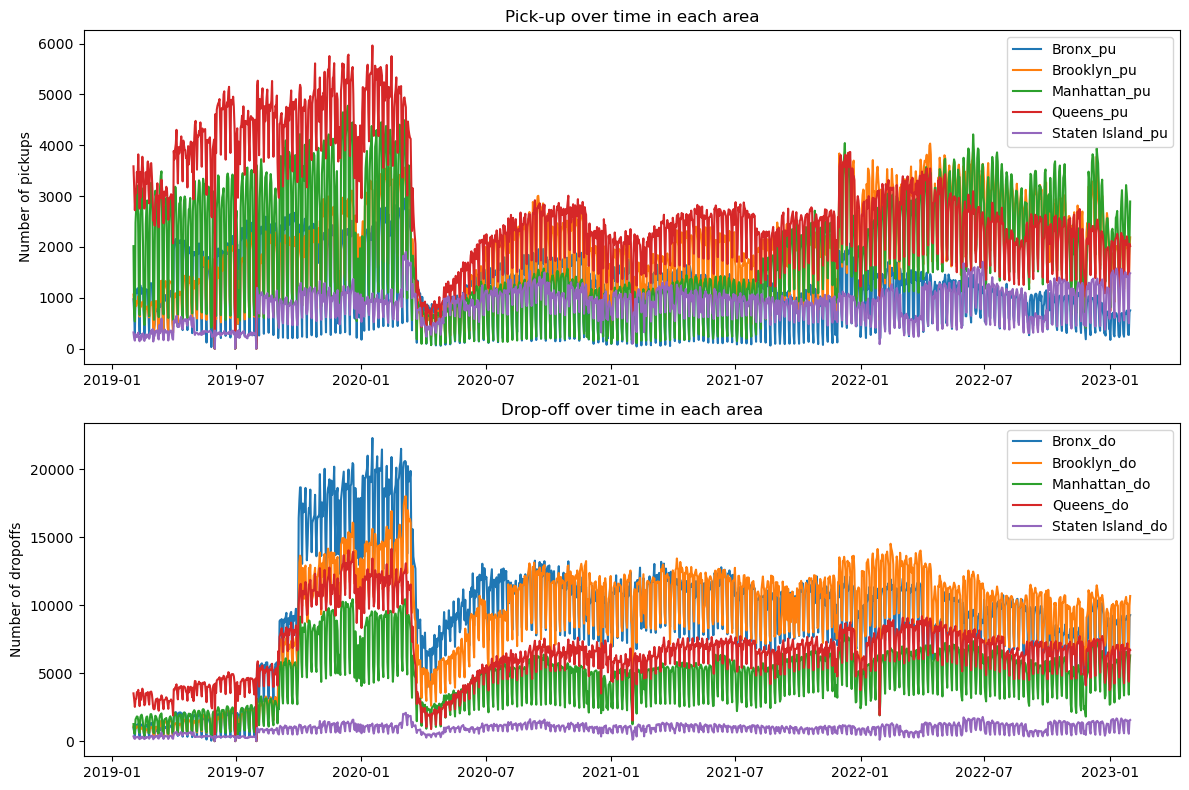

In [13]:
# Plot the change in demand for the entire time period for each district
df = time_list_Borough

# Create two subgraphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Draw the first subdiagram
ax1.plot(df['date'], df['Bronx_pu'], label='Bronx_pu')
ax1.plot(df['date'], df['Brooklyn_pu'], label='Brooklyn_pu')
ax1.plot(df['date'], df['Manhattan_pu'], label='Manhattan_pu')
ax1.plot(df['date'], df['Queens_pu'], label='Queens_pu')
ax1.plot(df['date'], df['Staten Island_pu'], label='Staten Island_pu')
# ax1.plot(df['date'], df['Unknown'], label='Unknown')
ax1.set_title('Pick-up over time in each area')
# ax1.set_xlabel('Date')
ax1.set_ylabel('Number of pickups')
ax1.legend()

# Drawing the second subdiagram
ax2.plot(df['date'], df['Bronx_do'], label='Bronx_do')
ax2.plot(df['date'], df['Brooklyn_do'], label='Brooklyn_do')
ax2.plot(df['date'], df['Manhattan_do'], label='Manhattan_do')
ax2.plot(df['date'], df['Queens_do'], label='Queens_do')
ax2.plot(df['date'], df['Staten Island_do'], label='Staten Island_do')
# ax2.plot(df['date'], df['Unknown'], label='Unknown')
ax2.set_title('Drop-off over time in each area')
# ax2.set_xlabel('Date')
ax2.set_ylabel('Number of dropoffs')
ax2.legend()

plt.tight_layout()
plt.show()

C:\Users\29425\AppData\Local\Temp\ipykernel_19748\54675944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


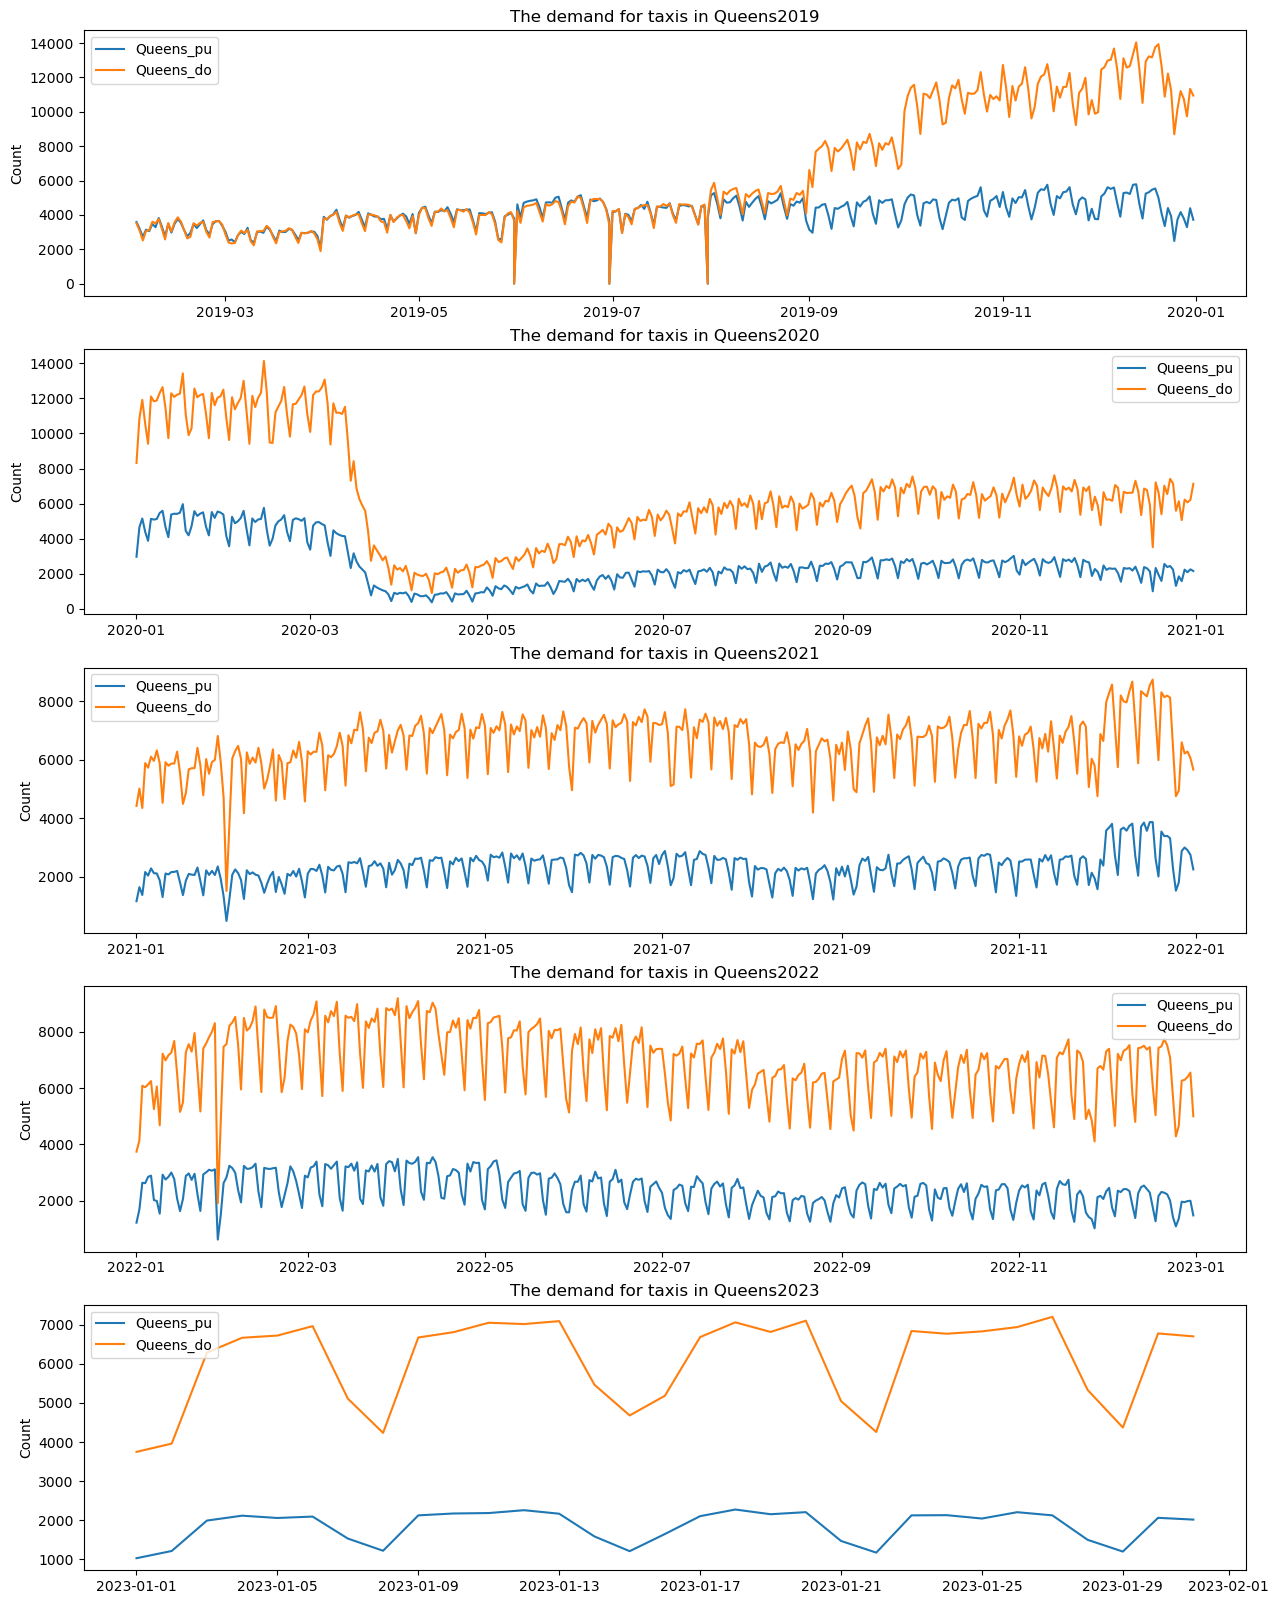

In [14]:
df = time_list_Borough[['date','Queens_do', 'Queens_pu']]
df['date'] = pd.to_datetime(df['date'])
# Grouped by year
df_grouped = df.groupby(df['date'].dt.year)

# plot
fig, axs = plt.subplots(5, 1, figsize=(15, 20))
for i, (year, group) in enumerate(df_grouped):   
    axs[i].plot(group['date'], group['Queens_pu'], label='Queens_pu')
    axs[i].plot(group['date'], group['Queens_do'], label='Queens_do')
    axs[i].set_title('The demand for taxis in Queens' + str(year))
    # axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Count')
    axs[i].legend()

plt.show()

The analysis showed that the demand for taxi services varied greatly across different TLC zones. Some zones consistently experienced high demand throughout the study period, while others showed more fluctuation. Additionally, some zones showed clear seasonal patterns in demand, such as higher demand during the summer months and lower demand during the winter months.

Furthermore, I also identified zones that exhibited significant changes in demand over time. For example, some previously low-demand zones experienced a sudden surge in demand during certain months, while some high-demand zones experienced a decline in demand. These findings are valuable for transportation planners and taxi companies to optimize their service deployment and marketing strategies to better meet the changing demand patterns in different regions of the city.


<hr>

## 4 Methodology 

This study aims to predict the demand for taxis in New York City based on spatiotemporal features using two machine learning algorithms: random forest (RF) and long short-term memory (LSTM).   
The regression relationship between taxi demand and time and location is defined as follows:    
$$Demand_{taxi} = f(Year,Month,Day,Hour,Weekday,LocationID)$$    
The dataset used in this study contains taxi trip records from 2016 to 2022, and a weak cleaning decision is made to handle missing values in the "PULocationID" and "DOLocationID" fields. Exploratory data analysis reveals that the demand for taxis has a certain cyclical pattern each year, except for 2020, where it experienced a significant decline in the first half of the year followed by a gradual increase towards a stable cyclic state. Both RF and LSTM models are trained and evaluated using Pearson correlation coefficient($R^2$) and root mean squared error (RMSE). The results will provide insights into the spatiotemporal characteristics of taxi demand in New York City, which can be useful for urban transportation planning and management.

<hr>

## 5 Analysis

### 5.1 Training data preparation

To facilitate training data, all vehicle records were read in this paper and the number of pickups per hour in each area was calculated. The results were then stored as raw data sets in a data frame for further analysis.

In [15]:
# Set the path to the FHV data directory
fhv_data_dir = "data/FHV_data"

# Initialize an empty origin_data_ml dataframe
origin_data_ml = pd.DataFrame(None, columns=["count", "time","locationID"])

# Read CSV lookup file
df_lookup = pd.read_csv('data/taxi_zone_lookup.csv')
df_lookup['LocationID'] = df_lookup['LocationID'].astype('category')

In [16]:
# Iterate through the parquet files under all years in the FHV_data folder
for year_dir in tqdm(os.listdir(fhv_data_dir), desc="Reading File:"):
    year_path = os.path.join(fhv_data_dir, year_dir)
    if os.path.isdir(year_path) and year_dir.isdigit() and int(year_dir) >= 2019:
        for file_name in tqdm(os.listdir(year_path), desc="Calcualting:"):
            if file_name.endswith(".parquet"):
                file_path = os.path.join(year_path, file_name)
                # print('read:'+ file_path)
                # Read parquet file and convert to pandas dataframe
                table = pq.read_table(file_path)
                df = table.to_pandas(safe=False)
                df = df[['pickup_datetime', 'PUlocationID']].dropna()
                
                # Verify that the pickup_datetime is within the year range indicated by the name of the folder where the file is located
                pickup_dates = pd.to_datetime(df["pickup_datetime"])
                mask = (pickup_dates.dt.year == int(year_dir))
                df = df[mask]

                # Resample and count data by hour
                hourly_counts = df.groupby([pd.Grouper(key='pickup_datetime', freq='H'), 'PUlocationID'])['PUlocationID'].count()

                # Convert MultiIndex to a normal DataFrame and rename the column names
                hourly_counts = hourly_counts.reset_index(name='count')

                # Split the pickup_datetime column for the time and hour columns
                hourly_counts['time'] = hourly_counts['pickup_datetime'].dt.strftime('%Y-%m-%d %H:00:00')
                hourly_counts['hour'] = hourly_counts['pickup_datetime'].dt.hour

                # Select the desired columns and reorder them
                hourly_counts = hourly_counts[['count', 'time', 'hour', 'PUlocationID']].sort_values(['time', 'hour', 'PUlocationID'])

                # Rename the PUlocationID column to locationID
                hourly_counts = hourly_counts.rename(columns={'PUlocationID': 'locationID'})
                hourly_counts = hourly_counts[['count', 'time', 'locationID']]

                # Data Append
                origin_data_ml = pd.concat([origin_data_ml, hourly_counts], ignore_index=True)
                
                # Release all variable values created in the above step, except for origin_data_ml
                del file_path, df, pickup_dates, mask, hourly_counts

# Sort origin_data_ml by date and set date as index
origin_data_ml = origin_data_ml.dropna(subset=['time'])
origin_data_ml = origin_data_ml.sort_values("time").reset_index(drop=True)


Reading File:: 100%|██████████| 6/6 [01:01<00:00, 10.29s/it]


In [17]:
# Type conversion and data extension
origin_data_ml['count'] = origin_data_ml['count'].astype(int)
origin_data_ml['time'] = pd.to_datetime(origin_data_ml['time'])
origin_data_ml['locationID'] = origin_data_ml['locationID'].astype(int).astype(str)

origin_data_ml['YYYY'] = origin_data_ml['time'].dt.year
origin_data_ml['MM'] = origin_data_ml['time'].dt.month
origin_data_ml['DD'] = origin_data_ml['time'].dt.day
origin_data_ml['HH'] = origin_data_ml['time'].dt.hour
origin_data_ml['weekday'] = origin_data_ml['time'].dt.weekday

# origin_data_ml
# Show the information of the data
origin_data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011678 entries, 0 to 4011677
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   count       int32         
 1   time        datetime64[ns]
 2   locationID  object        
 3   YYYY        int32         
 4   MM          int32         
 5   DD          int32         
 6   HH          int32         
 7   weekday     int32         
dtypes: datetime64[ns](1), int32(6), object(1)
memory usage: 153.0+ MB


### 5.2 RF

In [18]:
# Backup data based on source data
origin_data_ml_RF = origin_data_ml
origin_data_ml_RF = origin_data_ml_RF.query('YYYY>2018')
origin_data_ml_RF

,count,time,locationID,YYYY,MM,DD,HH,weekday
0,4,2019-02-01 00:00:00,7,2019,2,1,0,4
1,22,2019-02-01 00:00:00,132,2019,2,1,0,4
2,1,2019-02-01 00:00:00,137,2019,2,1,0,4
3,3,2019-02-01 00:00:00,138,2019,2,1,0,4
4,1,2019-02-01 00:00:00,140,2019,2,1,0,4
...,...,...,...,...,...,...,...,...
4011673,1,2023-01-31 23:00:00,76,2023,1,31,23,1
4011674,1,2023-01-31 23:00:00,75,2023,1,31,23,1
4011675,1,2023-01-31 23:00:00,74,2023,1,31,23,1
4011676,5,2023-01-31 23:00:00,68,2023,1,31,23,1


In [19]:
# Set XY
features = ['locationID', 'YYYY', 'MM', 'DD', 'HH', 'weekday']
target = 'count'
X = origin_data_ml_RF[features]
y = origin_data_ml_RF[target]

In [20]:
le = LabelEncoder()
X['locationID'] = le.fit_transform(X['locationID'])

C:\Users\29425\AppData\Local\Temp\ipykernel_19748\836547130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['locationID'] = le.fit_transform(X['locationID'])


In [21]:
# Data segmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Based on the preprocessed raw data, the optimal parameter settings were obtained through cross-validation using one month of data, with a maximum depth of 30 and a minimum sample size of 10 for the random forest algorithm.

In [23]:
# rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
# One month's data Time spent 10s
randomState_dt = 10000
rf_final = RandomForestRegressor(max_depth=30, min_samples_split=10, random_state=randomState_dt)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_split=10, random_state=10000)

In [24]:
print("R2 on the training data:")
print(rf_final.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(rf_final.score(X=X_test, y=y_test))

print("RMSE on the training data:")
print(mean_squared_error(y_train, rf_final.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, rf_final.predict(X_test), squared=False))

R2 on the training data:
0.9952610075291242
R2 on the testing data:
0.9912528187383552
RMSE on the training data:
8.097522555794404
RMSE on the testing data:
11.291533981822207


The model was trained using different data set sizes and evaluated using R2 and RMSE values obtained from the training and testing sets.   

The table below shows the corresponding data ranges and model training results.

|No.|Data range|Time cost|*R2* training data|*R2* testing data|*RMSE* training data|*RMSE* testing data|
|--|--|--|--|--|--|--|
|1|2023.01-2023.01|10s |0.79|0.62|1.16|1.54|
|2|2022.01-2023.01|4mins|0.81|0.66|1.22|1.66|
|3|2021.01-2023.01|8mins|0.83|0.69|1.20|1.64|
|4|2020.01-2023.01|12mins|0.99|0.99|4.47|5.60|
|5|2019.02-2023.01|21mins|0.99|0.99|8.61|12.1|


### 5.3 LSTM

Based on the preprocessed raw data, the data was normalized to reduce the potential impact of different data scales on the model training results. 

**Note**: since LSTM is a deep learning algorithm, the model training time is huge when the data size is extremely large. Therefore, in this case, only the data for January 2023 was used for model training and validation, aiming to test the technical path.

In [25]:
# Backup data based on source data
origin_data_ml_LSTM = origin_data_ml
origin_data_ml_LSTM = origin_data_ml_LSTM.query('YYYY>2022')
origin_data_ml_LSTM

,count,time,locationID,YYYY,MM,DD,HH,weekday
3924909,1,2023-01-01 00:00:00,209,2023,1,1,0,6
3924910,1,2023-01-01 00:00:00,179,2023,1,1,0,6
3924911,3,2023-01-01 00:00:00,181,2023,1,1,0,6
3924912,3,2023-01-01 00:00:00,186,2023,1,1,0,6
3924913,1,2023-01-01 00:00:00,187,2023,1,1,0,6
...,...,...,...,...,...,...,...,...
4011673,1,2023-01-31 23:00:00,76,2023,1,31,23,1
4011674,1,2023-01-31 23:00:00,75,2023,1,31,23,1
4011675,1,2023-01-31 23:00:00,74,2023,1,31,23,1
4011676,5,2023-01-31 23:00:00,68,2023,1,31,23,1


In [26]:
# Convert locationID to a numeric type
origin_data_ml_LSTM['locationID'] = pd.to_numeric(origin_data_ml_LSTM['locationID'])
df = origin_data_ml_LSTM

# Select the variables to be used
data = df[['count', 'locationID', 'YYYY', 'MM', 'DD', 'HH', 'weekday']].values
# data

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data.shape

C:\Users\29425\AppData\Local\Temp\ipykernel_19748\3763282484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_data_ml_LSTM['locationID'] = pd.to_numeric(origin_data_ml_LSTM['locationID'])


(86769, 7)

Based on the results of the data exploration analysis, the training set and the test set were divided in a ratio of 4:1. At the same time, the time step (i.e., Look back tick) was set to 1000.

An LSTM model was created and trained, and the final results were evaluated using R2 and RMSE.

In [27]:
# Dividing the training set and test set
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

# Create training set and test set
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Training set division, set time step
look_back = 1000
train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)

In [28]:
# Create and train LSTM models
model = Sequential()
model.add(LSTM(units=100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_Y, epochs=10, batch_size=70, verbose=2)

Epoch 1/10
978/978 - 2068s - loss: 0.0047 - 2068s/epoch - 2s/step
Epoch 2/10
978/978 - 2311s - loss: 0.0046 - 2311s/epoch - 2s/step
Epoch 3/10
978/978 - 2283s - loss: 0.0046 - 2283s/epoch - 2s/step
Epoch 4/10
978/978 - 2335s - loss: 0.0045 - 2335s/epoch - 2s/step
Epoch 5/10
978/978 - 2421s - loss: 0.0045 - 2421s/epoch - 2s/step
Epoch 6/10
978/978 - 2472s - loss: 0.0045 - 2472s/epoch - 3s/step
Epoch 7/10
978/978 - 2466s - loss: 0.0045 - 2466s/epoch - 3s/step
Epoch 8/10
978/978 - 2647s - loss: 0.0045 - 2647s/epoch - 3s/step
Epoch 9/10
978/978 - 2651s - loss: 0.0045 - 2651s/epoch - 3s/step
Epoch 10/10
978/978 - 2647s - loss: 0.0045 - 2647s/epoch - 3s/step


In [29]:
# Predicted count value
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

512/512 [==============================] - 84s 165ms/step


In [30]:
print("R2 on the training data:")
print(r2_score(train_Y, train_predict))
print("R2 on the testing data:")
print(r2_score(test_Y, test_predict))

print("RMSE on the training data:")
print(mean_squared_error(train_Y, train_predict, squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_Y, test_predict, squared=False))

R2 on the training data:
0.06963822503312467
R2 on the testing data:
0.058300364454621945
RMSE on the training data:
0.06668118597285293
RMSE on the testing data:
0.06663205516214303


Text(0, 0.5, 'Value')

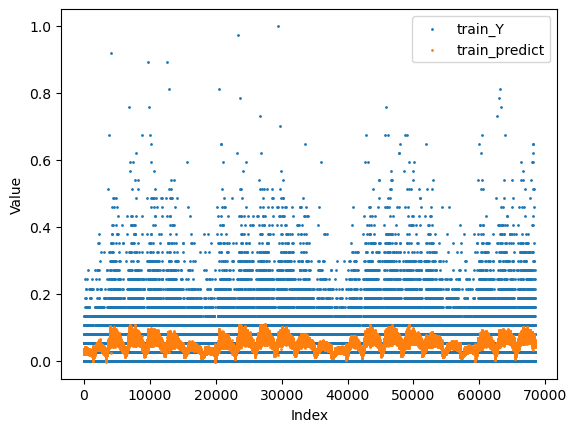

In [31]:
# Get the length index sequence of x-axis
x = np.arange(len(train_Y))

# Plotting scatter plots
plt.scatter(x, train_Y,s=1, label='train_Y')
plt.scatter(x, train_predict, s=1, label='train_predict')

# Adding legends and labels
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')

The LSTM algorithm is used to obtain the model prediction results as:

|Data range|Time cost|*R2* training data|*R2* testing data|*RMSE* training data|*RMSE* testing data|
|--|--|--|--|--|--|
|2023.01-2023.01|5h|0.0624|0.0524|0.0669|0.0668|

<hr>

## 6 Results and Discussion

### 6.1 The result analysis of random forest

Based on the results obtained from the random forest algorithm, it can be concluded that as the range of training data increases, the model's training time increases, and the model's performance and error remain within an acceptable range. However, between training scenarios 4 and 5, the value of RMSE increases as the time range of the training set increases. From the content of the training data, it can be inferred that this may be due to the impact of the COVID-19 pandemic, which led to a sharp drop in demand for car use between 2019 and 2020, resulting in different results for the model, but the error is within an acceptable range.    
Therefore, it can be considered that the prediction of regional taxi demand in New York City based on the random forest algorithm is successful.

### 6.2 The result analysis of LSTM

The LSTM algorithm's training results were relatively unsatisfactory, with an R2 result close to zero, indicating a significant deviation between predicted and actual results. However, from the scatter plot of predicted and true values, the LSTM model learned the periodicity of the original data well.   

Possible reasons for the poor training results are as follows:   

1. Insufficient training data, requiring more data to be added.
2. The time period setting may be inappropriate and multiple trainings with cross-validation are needed.

<hr>

## 7 Conclusion

In conclusion, the results of this study suggest that the random forest algorithm is a promising approach for predicting taxi demand in urban areas. By using cross-validation and selecting the optimal hyperparameters, the model was able to achieve high levels of accuracy in both the training and testing datasets. Furthermore, the use of data normalization improved the performance of the model and helped to mitigate the effects of different data scales on the training process.   

On the other hand, although the LSTM algorithm shows great potential for predicting time series data, the computational complexity of the model limits its applicability in large-scale datasets. In this study, we tested the LSTM algorithm on a small-scale dataset and the results obtained were not very satisfactory. Therefore, further investigation is needed to assess the feasibility of applying the LSTM algorithm in large-scale cab demand forecasting.   

In summary, the use of machine learning algorithms such as random forest can improve the accuracy of taxi demand prediction, but the choice of algorithm should depend on the specific context and computational resources available.   


<hr>

## Bibliography

Deng, Z. and Ji, M. (2011). ‘Spatiotemporal structure of taxi services in Shanghai: Using exploratory spatial data analysis’. in 2011 19th International Conference on Geoinformatics. 2011 19th International Conference on Geoinformatics, Shanghai, China: IEEE, pp. 1–5. doi: 10.1109/GeoInformatics.2011.5981129.   

Li, B., Zhang, D., Sun, L., Chen, C., Li, S., Qi, G. and Yang, Q. (2011). ‘Hunting or waiting? Discovering passenger-finding strategies from a large-scale real-world taxi dataset’. in 2011 IEEE International Conference on Pervasive Computing and Communications Workshops (PERCOM Workshops). 2011 IEEE International Conference on Pervasive Computing and Communications Workshops (PerCom Workshops), Seattle, WA, USA: IEEE, pp. 63–68. doi: 10.1109/PERCOMW.2011.5766967.   

Moreira-Matias, L., Gama, J., Ferreira, M., Mendes-Moreira, J. and Damas, L. (2013). ‘Predicting Taxi–Passenger Demand Using Streaming Data’. IEEE Transactions on Intelligent Transportation Systems, 14 (3), pp. 1393–1402. doi: 10.1109/TITS.2013.2262376.   

Yang Yue, Yan Zhuang, Qingquan Li, and Qingzhou Mao. (2009). ‘Mining time-dependent attractive areas and movement patterns from taxi trajectory data’. in 2009 17th International Conference on Geoinformatics. 2009 17th International Conference on Geoinformatics, Fairfax, VA: IEEE, pp. 1–6. doi: 10.1109/GEOINFORMATICS.2009.5293469.   

Yu, Q., Li, W., Zhang, H. and Chen, J. (2022). ‘GPS data in taxi-sharing system: Analysis of potential demand and assessment of fuel consumption based on routing probability model’. Applied Energy, 314, p. 118923. doi: 10.1016/j.apenergy.2022.118923.   

Zhang, W., Qi, G., Pan, G., Lu, H., Li, S. and Wu, Z. (2015). ‘City-Scale Social Event Detection and Evaluation with Taxi Traces’. ACM Transactions on Intelligent Systems and Technology, 6 (3), pp. 1–20. doi: 10.1145/2700478.   

Investopedia. (2021, August 19). Historical timeline of COVID-19 in New York City. Retrieved from https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986   


<hr>

## Appendix

**Data Source**:   
TLC Trip Record Data - TLC: [https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)